# 잡음제거 오토인코더 모델

### 변경점
* 이미지 Size를 기존 (256,256)에서 (512,512)로 설정하여 선명도를 높혀보았습니다.

## 1. 데이터 로드

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
# from tensorflow.keras.layers import *

In [2]:
DATA_PATH = './Dataset/Denoising_Dataset/'
ORG_DATA_PATH = DATA_PATH + 'Original/'
NIS_DATA_PATH = DATA_PATH + 'Noisy/'
filepaths = os.listdir(ORG_DATA_PATH)

In [3]:
class Dataset(tf.keras.utils.Sequence):
    """ keras에 Sequence 클래스를 상속받아
    batchsize 만큼만 이미지를 load하는 DataLoader를 설계"""
    def __init__(self,
                 org_path,
                 nis_path,
                 filepaths,
                 batch_size=32,
                 target_size=(512,512),
                 shuffle=True):
        self.org_path = org_path
        self.nis_path = nis_path
        self.filepaths = filepaths
        self.batch_size = batch_size
        self.target_size = target_size
        if shuffle:
            np.random.shuffle(self.filepaths)
            
    def __getitem__(self, index):
        low = index*self.batch_size
        high = min(low + self.batch_size, len(self.filepaths))
        
        self.x = []
        self.y = []
        for p in self.filepaths[low:high]:
            # load
            org_img = cv2.imread(os.path.join(self.org_path, p))
            nis_img = cv2.imread(os.path.join(self.nis_path, p))
            # resize
            org_img = cv2.resize(org_img, dsize=self.target_size)
            nis_img = cv2.resize(nis_img, dsize=self.target_size)
            # scaling
            org_img = np.divide(org_img, 255.)
            nis_img = np.divide(nis_img, 255.)
            
            self.x.append(nis_img)
            self.y.append(org_img)
            
            return np.array(self.x), np.array(self.y)
            
        return np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)
            
    def __len__(self):
        return int(np.ceil(len(self.filepaths)//self.batch_size))

In [4]:
# 설계한 대로 데이터셋 선언
dataset = Dataset(org_path=ORG_DATA_PATH,
                 nis_path=NIS_DATA_PATH,
                 filepaths=filepaths)

In [5]:
x, y = next(iter(dataset))

(-0.5, 511.5, 511.5, -0.5)

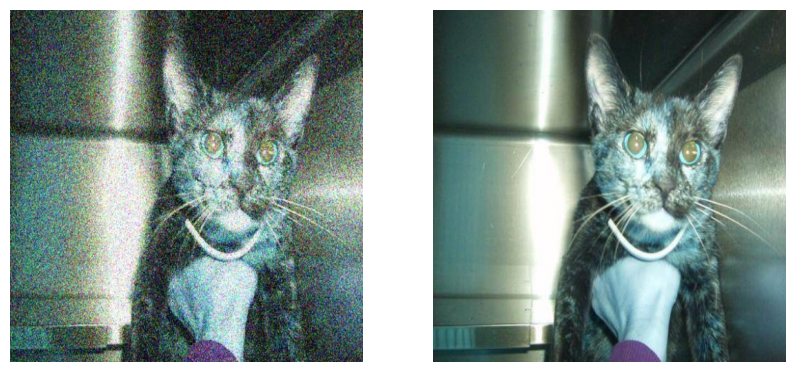

In [6]:
sample_x = x[0]
sample_y = y[0]
fig, axes = plt.subplots(1,2,figsize=(10,5))
axes[0].imshow(sample_x)
axes[1].imshow(sample_y)
axes[0].axis('off')
axes[1].axis('off')

In [7]:
del x,y

## 2. 모델링

In [8]:
# modeling
input_layer = tf.keras.layers.Input(shape=(512,512,3))
## Encoder
x = tf.keras.layers.Conv2D(16, kernel_size=3, strides=2, padding='same',
                          activation=None)(input_layer)

x = tf.keras.layers.Conv2D(32, kernel_size=3, strides=2, padding='same',
                          activation=None)(x)

x = tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same',
                          activation=None)(x)

## Latent vector
latent = tf.keras.layers.Conv2D(64, kernel_size=3, strides=1, padding='same',
                          activation=None)(x)
## Decoder

x = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3,strides=2,
                                   padding='same',
                                    activation=None)(x)
x = tf.keras.layers.Conv2DTranspose(filters=16, kernel_size=3,strides=2,
                                   padding='same',
                                    activation=None)(x)
x = tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=3,strides=2,
                                   padding='same',
                                   activation='sigmoid')(x)

model = tf.keras.models.Model(input_layer, x)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 128, 128, 32)      18464     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 256, 256, 16)      4624      
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 512, 512, 3)       435   

In [9]:
model.compile(loss='mse', optimizer='adam')

## 3. 모델 학습

In [27]:
model.fit(dataset, epochs=20)

Epoch 1/20
31/31 [==============================] - 1s 20ms/step - loss: 0.0032
Epoch 2/20
31/31 [==============================] - 0s 14ms/step - loss: 0.0031
Epoch 3/20
31/31 [==============================] - 0s 13ms/step - loss: 0.0033
Epoch 4/20
31/31 [==============================] - 0s 13ms/step - loss: 0.0034
Epoch 5/20
31/31 [==============================] - 0s 14ms/step - loss: 0.0034
Epoch 6/20
31/31 [==============================] - 0s 13ms/step - loss: 0.0037
Epoch 7/20
31/31 [==============================] - 0s 14ms/step - loss: 0.0032
Epoch 8/20
31/31 [==============================] - 0s 13ms/step - loss: 0.0034
Epoch 9/20
31/31 [==============================] - 0s 14ms/step - loss: 0.0035
Epoch 10/20
31/31 [==============================] - 0s 14ms/step - loss: 0.0033
Epoch 11/20
31/31 [==============================] - 0s 13ms/step - loss: 0.0035
Epoch 12/20
31/31 [==============================] - 0s 14ms/step - loss: 0.0032
Epoch 13/20
31/31 [==================

(-0.5, 499.5, 494.5, -0.5)

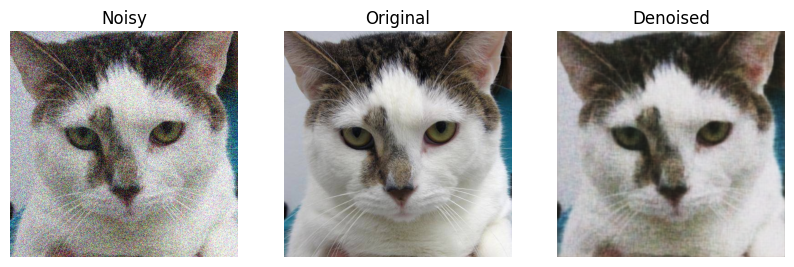

In [34]:
from functools import partial
# predict
rnd_idx = np.random.randint(0, len(filepaths), 1)[0]
noisy_smp = cv2.imread(os.path.join(NIS_DATA_PATH, filepaths[rnd_idx]))
org_smp = cv2.imread(os.path.join(ORG_DATA_PATH, filepaths[rnd_idx]))

input_img = cv2.resize(noisy_smp, (512,512))
input_img = np.divide(input_img, 255.)

denoised_img = model.predict(input_img[np.newaxis,...])
denoised_img = (denoised_img[0]*255.).astype(np.uint8)
denoised_img = cv2.resize(denoised_img, org_smp.shape[1::-1])

bgr2rgb = partial(cv2.cvtColor, code=cv2.COLOR_BGR2RGB)

# compare results
fig, axes = plt.subplots(1,3,figsize=(10,5))
axes[0].imshow(bgr2rgb(noisy_smp))
axes[1].imshow(bgr2rgb(org_smp))
axes[2].imshow(bgr2rgb(denoised_img))
axes[0].set_title('Noisy'); axes[0].axis('off')
axes[1].set_title('Original'); axes[1].axis('off')
axes[2].set_title('Denoised'); axes[2].axis('off')

## Result

* 검증 데이터 만들기 : 시도해보았으나 방법을 잘 모르겠습니다.
* 모델 구조 변경 : 모델 층을 늘리거나 더 단순하게 만들어 시도해보았으나 더 나은 결과를 보이지 않았습니다.
* 잡음은 효과적으로 제거하지만 선명도는 떨어지는 것을 확인하였습니다.